This notebook is modified from the example/channel_response.ipynb of the original repo: https://github.com/ant-uni-bremen/OpenNTN/

In [458]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import numpy as np

from sionna.phy.ofdm import ResourceGrid
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel

# These functions also exist in sionna.channel.tr38901 but are not compatable with 3GPP TR38.811
from sionna.phy.channel.tr38901 import Antenna, AntennaArray

In [459]:
# Import the NTN channel models from the local OpenNTN package
import sys
sys.path.append('../')  # Add parent directory to path to access OpenNTN
from OpenNTN import DenseUrban, Urban, SubUrban
from OpenNTN.utils import gen_single_sector_topology as gen_ntn_topology

In [ ]:
scenario = "dur" # dur is the DenseUrban scenario
carrier_frequency = 2.18e9 # DL S-Band
direction = "downlink"
elevation_angle = 50.0
num_ut = 1
satellite_height = 600000.0 # Height in meters, this is a satellite in the Low Earth Orbit (LEO)
batch_size = 32 # Number of topologies we will generate later  

In [461]:
ut_array = Antenna(polarization="single",
                    polarization_type="V",
                    antenna_pattern="omni",
                    carrier_frequency=carrier_frequency)

# The satellite is the basestation, so we name it bs. 
bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
N_samples = 2048
H_perfect = [] # to be in size of [14,132,N]

In [462]:
num_streams_per_tx = 1 
num_time_steps = 14
sampling_frequency = 76800000 # set equal to waveformInfo.SampleRate in MATLAB
        # maybe different because in MATLAB, number of subcariers is different to the Nfft

rg = ResourceGrid(num_ofdm_symbols=14,
                    fft_size=132, # in MATLAB, it is 256, even number of subcarriers is 132
                    subcarrier_spacing=30e3,
                    num_tx=num_ut,
                    num_streams_per_tx=num_streams_per_tx,
                    cyclic_prefix_length=20,
                    pilot_pattern="kronecker",
                    pilot_ofdm_symbol_indices=[2,11])

# Function that calculates the subcarrier frequencies of the OFDM frame
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

In [463]:
from OpenNTN.utils import compute_stallite_doppler as compute_stallite_doppler 

In [479]:
aa = compute_stallite_doppler(satellite_height, elevation_angle, carrier_frequency)
aa

<tf.Tensor: shape=(), dtype=float32, numpy=2000029696.0>

In [465]:
for i in range(N_samples//(batch_size *2)):
    # Here we match choose DenseUrban to match the parameter "dur" for the scenario defined above
    channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                            ut_array=ut_array,
                            bs_array=bs_array,
                            direction=direction,
                            elevation_angle=elevation_angle)

    # Generate the topology
    topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario,bs_height=satellite_height)

    # Set the topology
    channel_model.set_topology(*topology)

    # path_coefficients [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    # path_delays [batch size, num_rx, num_tx, num_paths]
    path_coefficients, path_delays = channel_model(num_time_steps, sampling_frequency)
    h = cir_to_ofdm_channel(frequencies, path_coefficients, path_delays)

    h_1 = tf.transpose(h[:,0,0,0,0,:,:], perm=[1, 2, 0])  # (32,14,132) -> (14,132,32)
    h_2 = tf.transpose(h[:,0,0,0,1,:,:], perm=[1, 2, 0])  # (32,14,132) -> (14,132,32)
    H_perfect.append(h_1)
    H_perfect.append(h_2)
    

In [466]:
H_perfect = tf.concat(H_perfect, axis=-1) # H to save: [14, 132, N]
H_perfect.shape

TensorShape([14, 132, 2048])

In [467]:
import scipy.io

H_perfect_numpy = H_perfect.numpy()
scipy.io.savemat('H_perfect.mat', {'H_perfect': H_perfect_numpy})

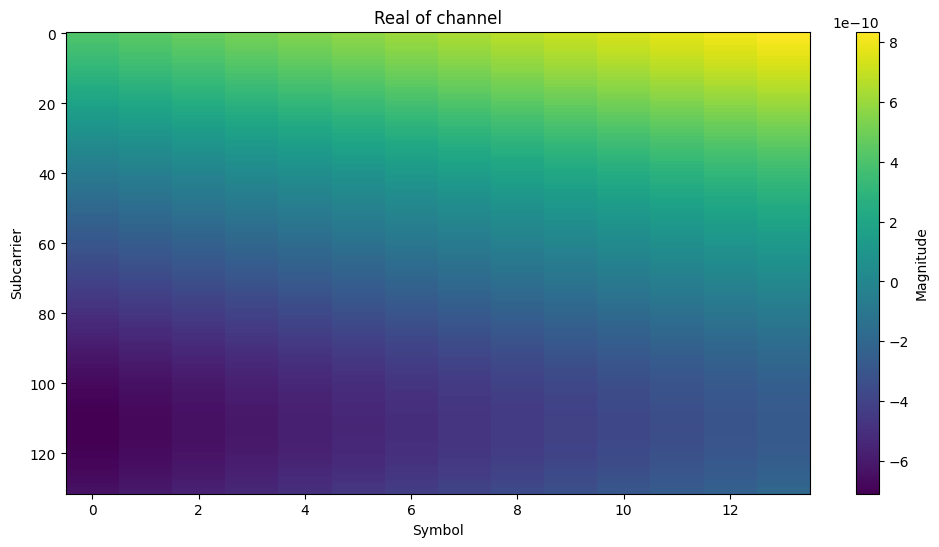

In [482]:
h_freq_plot = (H_perfect[:,:,100]).numpy().real
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Real of channel')
plt.show()

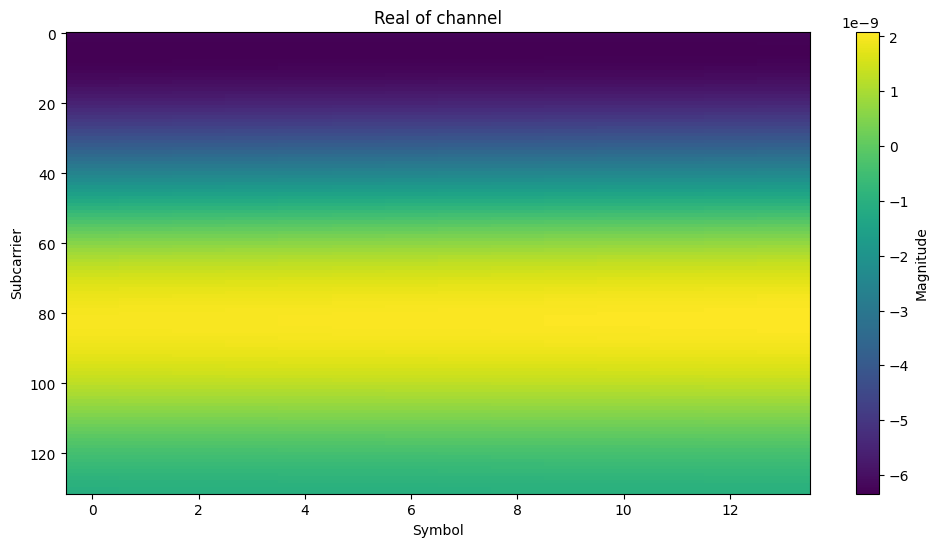

In [469]:
h_freq_plot = (H_perfect[:,:,6]).numpy().real
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Real of channel')
plt.show()

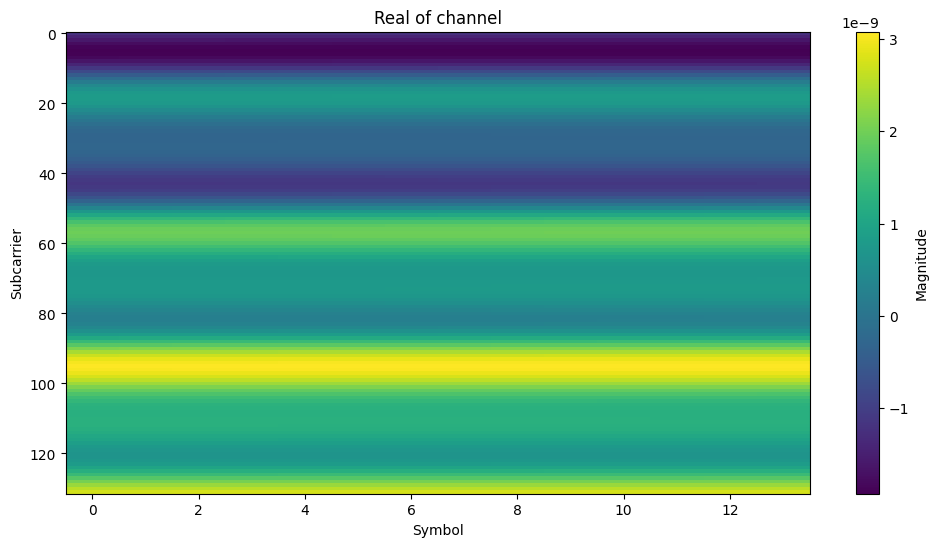

In [470]:
h_freq_plot = (h[19,  0,0,  0,0,  :,:]).numpy().real
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Real of channel')
plt.show()

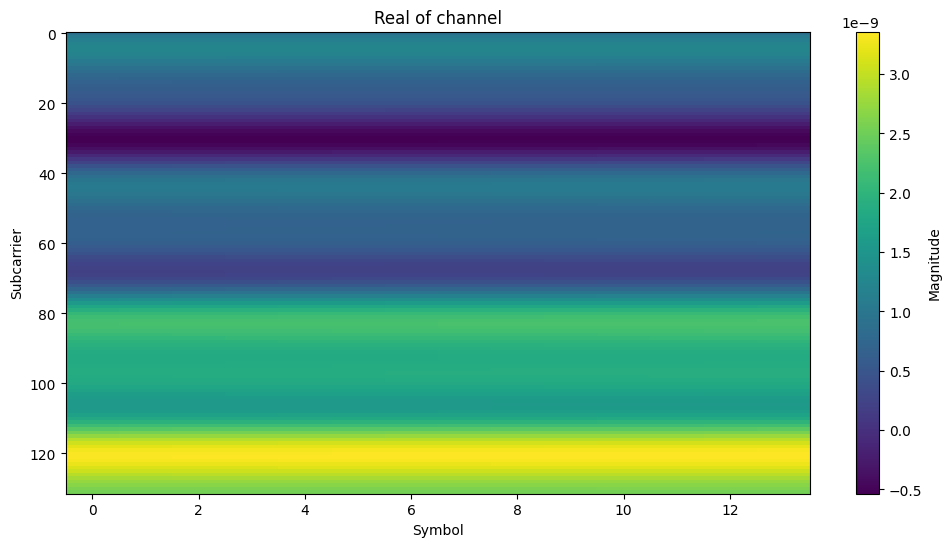

In [471]:
h_freq_plot = (h[19,  0,0,  0,1,  :,:]).numpy().real
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Real of channel')
plt.show()

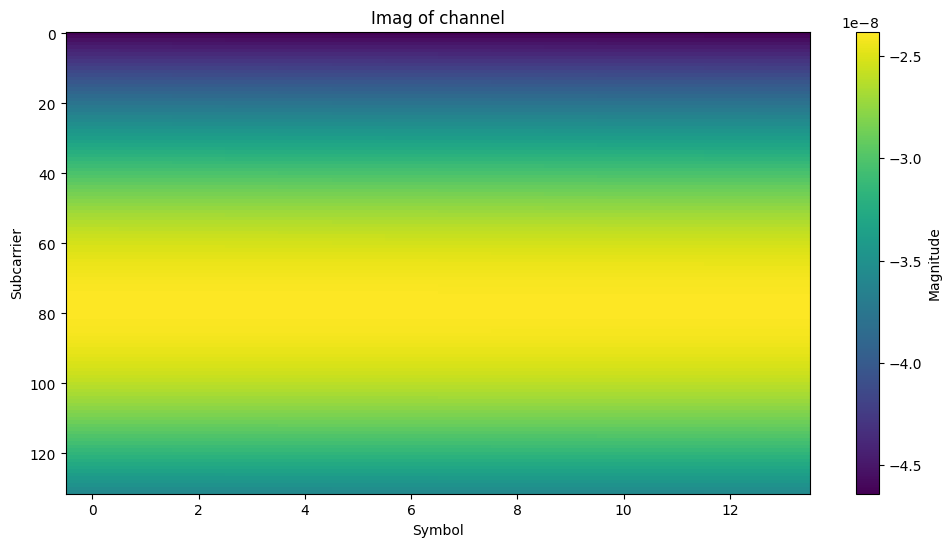

In [472]:
h_freq_plot = (h[0,0,0,0,0,:,:]).numpy().imag
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Imag of channel')
plt.show()

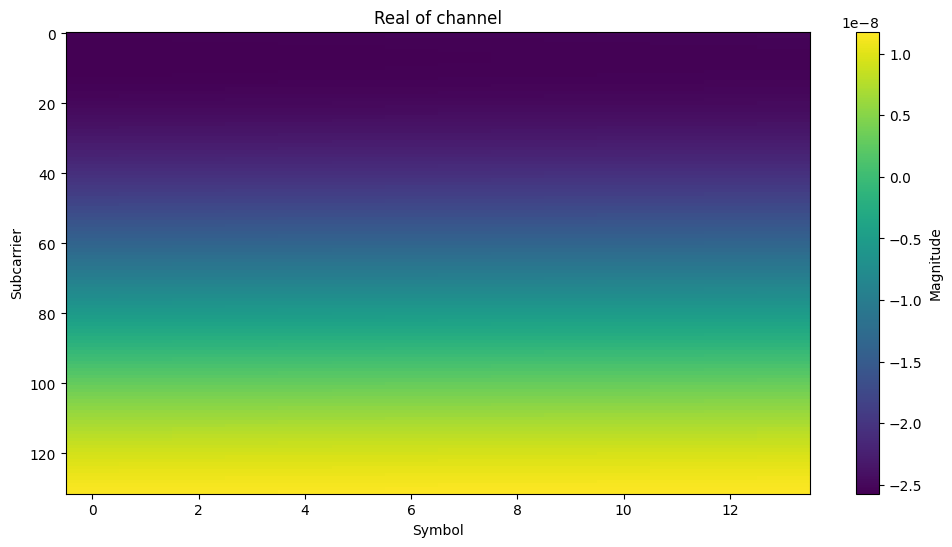

In [473]:
h_freq_plot = (h[0,0,0,0,0,:,:]).numpy().real
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Real of channel')
plt.show()

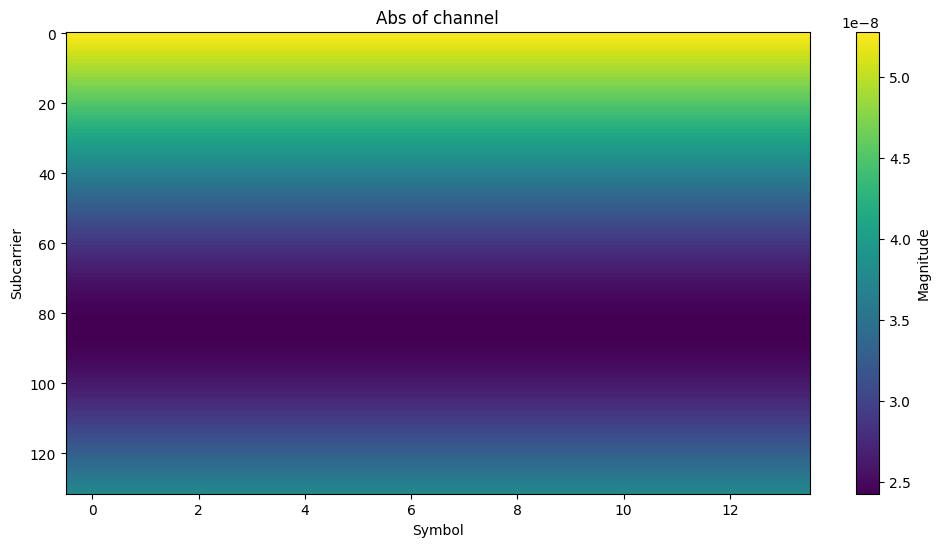

In [474]:
h_freq_plot = tf.abs(h[0,0,0,0,0,:,:]).numpy() 
h_freq_plot = h_freq_plot.T

# Plot the concatenated heatmap
plt.figure(figsize=(12, 6))
plt.imshow(h_freq_plot, aspect='auto', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Symbol')
plt.ylabel('Subcarrier')
plt.title('Abs of channel')
plt.show()